### TO DO LIST:
<ol type="decimal">
  <li>Preparação e exploração dos dados</li>
  <li>Métricas de qualidade e validação de modelos</li>
  <li>Árvores de decisão</li>
  <li>Regressão linear e logística</li>
</ol>

# TAREFA DATASET GRUPO

**Nota: Melhorar Descrição** 

Para esta fase, decidimos escolher um dataset referente a avaliações de vinhos. 
Pode ser encontrado neste link: https://www.kaggle.com/datasets/zynicide/wine-reviews
O objetivo desta fase é, através deste dataset, inferir acerca do valor de points que será dado a um dado vinho.

**1.** Importar as bibliotecas essenciais do Python para a elaboração desta tarefa

In [63]:
import sklearn as skl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

**2.** Carregar o dataset para um dataframe da biblioteca Panda 

In [64]:
df = pd.read_csv('docs/winemag-data-130k-v2.csv', encoding="utf-8", skipinitialspace=True)

**3.** Obtenção de informação acerca do dataset: tipos de dados das features, conteúdo do dataset e estatística

* tipos de dados das features;

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


* conteúdo do dataset;

In [66]:
df

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


* estatística;

In [67]:
df.describe()

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


<AxesSubplot:>

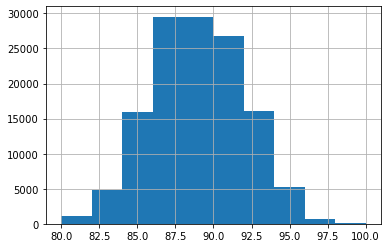

In [68]:
df.points.hist()

<AxesSubplot:>

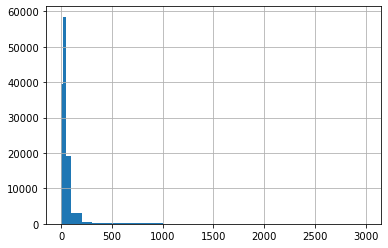

In [69]:
df.price.hist(bins=[0,20,50,100,200,300,1000,2000,2500,3000])

In [70]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [71]:
df[df.title.str.contains(r'.*\d{4}.*')]

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


**4.** Preparação dos dados

In [72]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [73]:
df.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

In [74]:
#Remoção de algumas features que considerámos desnecessárias
remove_features_list = ["Unnamed: 0",'designation', "description",'region_1', "region_2", "taster_twitter_handle"]
for ft in remove_features_list:
    df = df.drop(ft, axis=1)

In [75]:
for c in df:
    print(f"{c}: {df[c].unique()}")
    print(df[c].nunique())

country: ['Italy' 'Portugal' 'US' 'Spain' 'France' 'Germany' 'Argentina' 'Chile'
 'Australia' 'Austria' 'South Africa' 'New Zealand' 'Israel' 'Hungary'
 'Greece' 'Romania' 'Mexico' 'Canada' nan 'Turkey' 'Czech Republic'
 'Slovenia' 'Luxembourg' 'Croatia' 'Georgia' 'Uruguay' 'England' 'Lebanon'
 'Serbia' 'Brazil' 'Moldova' 'Morocco' 'Peru' 'India' 'Bulgaria' 'Cyprus'
 'Armenia' 'Switzerland' 'Bosnia and Herzegovina' 'Ukraine' 'Slovakia'
 'Macedonia' 'China' 'Egypt']
43
points: [ 87  86  85  88  92  91  90  89  83  82  81  80 100  98  97  96  95  93
  94  84  99]
21
price: [  nan   15.   14.   13.   65.   16.   24.   12.   27.   19.   30.   34.
   28.   32.   23.   20.   22.   35.   69.   10.   17.   50.   21.   11.
    9.   40.   55.  100.   25.   58.   26.   46.   75.   18.   29.   85.
   44.   80.   70.   36.   39.   45.   48.   68.   78.   60.  112.   84.
   64.   38.   95.   62.   57.   49.   37.   52.   41.  215.  125.   56.
    7.   42.  350.  775.  225.  150.  320.  630.  365.   

In [76]:
# Remoção de registos duplicados (caso hajam)
df.drop_duplicates()

,country,points,price,province,taster_name,title,variety,winery
0,Italy,87,NaN,Sicily & Sardinia,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,87,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,87,65.0,Oregon,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...
129966,Germany,90,28.0,Mosel,Anna Lee C. Iijima,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,90,75.0,Oregon,Paul Gregutt,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,90,30.0,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,90,32.0,Alsace,Roger Voss,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


In [77]:
df[df.title.str.contains(r'Merlot-Cabernet Franc Red \(Paarl\)')]

,country,points,price,province,taster_name,title,variety,winery
18881,South Africa,90,20.0,Paarl,Lauren Buzzeo,Glen Carlou 2009 Grand Classique Cabernet Sauv...,Bordeaux-style Red Blend,Glen Carlou


In [78]:
print(str(df.loc[df.index == 18881].title.values))

['Glen Carlou 2009 Grand Classique Cabernet Sauvignon-Petit Verdot-Malbec-\r\nMerlot-Cabernet Franc Red (Paarl)']


In [79]:
df.title = df.title.str.replace(r'(.|\n)*(\d{4})(.|\n)*',r'\2',regex=True)
df.title = df.title[df.title.str.contains(r'\d{4}')]
df


,country,points,price,province,taster_name,title,variety,winery
0,Italy,87,NaN,Sicily & Sardinia,Kerin O’Keefe,2013,White Blend,Nicosia
1,Portugal,87,15.0,Douro,Roger Voss,2011,Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Paul Gregutt,2013,Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,Alexander Peartree,2013,Riesling,St. Julian
4,US,87,65.0,Oregon,Paul Gregutt,2012,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...
129966,Germany,90,28.0,Mosel,Anna Lee C. Iijima,2013,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,90,75.0,Oregon,Paul Gregutt,2004,Pinot Noir,Citation
129968,France,90,30.0,Alsace,Roger Voss,2013,Gewürztraminer,Domaine Gresser
129969,France,90,32.0,Alsace,Roger Voss,2012,Pinot Gris,Domaine Marcel Deiss


In [80]:
rename_map = {'title':'year'}
df.rename(columns=rename_map,inplace=True)
df

,country,points,price,province,taster_name,year,variety,winery
0,Italy,87,NaN,Sicily & Sardinia,Kerin O’Keefe,2013,White Blend,Nicosia
1,Portugal,87,15.0,Douro,Roger Voss,2011,Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Paul Gregutt,2013,Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,Alexander Peartree,2013,Riesling,St. Julian
4,US,87,65.0,Oregon,Paul Gregutt,2012,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...
129966,Germany,90,28.0,Mosel,Anna Lee C. Iijima,2013,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,90,75.0,Oregon,Paul Gregutt,2004,Pinot Noir,Citation
129968,France,90,30.0,Alsace,Roger Voss,2013,Gewürztraminer,Domaine Gresser
129969,France,90,32.0,Alsace,Roger Voss,2012,Pinot Gris,Domaine Marcel Deiss


In [81]:
df.year = df.year.astype(int)

ValueError: cannot convert float NaN to integer

In [82]:
# Remoção de linhas que não contêm pontos
df = df.dropna(subset=["points"])

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129908 non-null  object 
 1   points       129971 non-null  int64  
 2   price        120975 non-null  float64
 3   province     129908 non-null  object 
 4   taster_name  103727 non-null  object 
 5   year         125362 non-null  object 
 6   variety      129970 non-null  object 
 7   winery       129971 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 8.9+ MB


In [84]:
columns = df.columns.values
for c in columns:
    print(f"{c} : {df[c].nunique()}")

country : 43
points : 21
price : 390
province : 425
taster_name : 19
year : 168
variety : 707
winery : 16757


In [85]:
df.price.fillna(df.price.mean(),inplace =True)
df.country.fillna(str(df.country.mode()),inplace =True)
df.province.fillna(str(df.province.mode()),inplace =True)
df.taster_name.fillna('unknown',inplace =True)
df.year.fillna(df.year.median(),inplace=True)# In[ ]:
df.variety.fillna(str(df.variety.mode()),inplace =True)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129971 non-null  object 
 1   points       129971 non-null  int64  
 2   price        129971 non-null  float64
 3   province     129971 non-null  object 
 4   taster_name  129971 non-null  object 
 5   year         129971 non-null  object 
 6   variety      129971 non-null  object 
 7   winery       129971 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 8.9+ MB


In [87]:
df.drop('winery',axis=1,inplace=True)

In [88]:
for c in df.columns.values:
    if(df[c].dtype=='object'):
        print(c)
        labels = df[c].astype('category').cat.categories.tolist()
        replace_map_comp = {c : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
        df.replace(replace_map_comp,inplace=True)

df.head()


country
province
taster_name
year
variety


,country,points,price,province,taster_name,year,variety
0,24,87,35.363389,333,10,146,692
1,33,87,15.000000,110,16,144,452
2,42,87,14.000000,270,15,146,438
3,42,87,13.000000,220,1,146,481
4,42,87,65.000000,270,15,145,442


### **5.** Aplicação de modelos de Machine Learning

#### 5.1. Decision Tree regressor

In [89]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [90]:
x = df.drop(['points'],axis=1)
y = df['points'].to_frame()

In [91]:
x

,country,price,province,taster_name,year,variety
0,24,35.363389,333,10,146,692
1,33,15.000000,110,16,144,452
2,42,14.000000,270,15,146,438
3,42,13.000000,220,1,146,481
4,42,65.000000,270,15,145,442
...,...,...,...,...,...,...
129966,19,28.000000,234,2,146,481
129967,42,75.000000,270,15,137,442
129968,17,30.000000,13,16,146,211
129969,17,32.000000,13,16,145,438


In [92]:
y

,points
0,87
1,87
2,87
3,87
4,87
...,...
129966,90
129967,90
129968,90
129969,90


In [93]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=2021)

In [94]:
clf = DecisionTreeRegressor(random_state=2022)

In [95]:
clf.fit(x_train,y_train)

DecisionTreeRegressor(random_state=2021)

In [96]:
predictions = clf.predict(x_test)
predictions

array([89.66071429, 84.88888889, 87.5       , ..., 90.25      ,
       89.5       , 88.        ])

In [97]:
mean_absolute_error(y_test,predictions)

1.953434370389278

In [98]:
y_test

,points
78282,93
34783,86
73073,86
29687,88
39799,87
...,...
86911,88
320,86
121825,92
124977,88


pd.DataFrame(predictions)

In [101]:
from sklearn.model_selection import cross_val_score

#CROSS VALIDATION
N_FOLDS = 10
scores = cross_val_score(clf, x, y, cv=N_FOLDS)
print(scores)

[0.23466431 0.27017992 0.26444019 0.29937475 0.21507336 0.18083545
 0.2768293  0.2423118  0.27086672 0.31478767]


#### 5.2. Linear Regression